## Import Libraries
First import all the necessary libraries from Pytorch, Scikit-Learn, Numpy, Pandas, and Matplotlib. 

In [3]:
import numpy as np
import pandas as pd
from itertools import permutations
import copy
import os

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import functional as F

from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import r2_score

from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib as mpl

%matplotlib inline
mpl.rcParams['figure.dpi']= 200
seed = 1269

def set_seeds(seed):    
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

## Load Data
Load experimental data from the .csv file

In [5]:
data = pd.read_csv("Data/Part_Data/lego_data.csv", sep=';')
data = data[['Legobaustein', 'Testlauf', 'Max_Deformation', 'Nachdruck', 'Nachdruckzeit', 'Schmelzetemperatur', 'Wandtemperatur', 'Kuehlzeit', 'Volumenstrom']]
data.head()

,Legobaustein,Testlauf,Max_Deformation,Nachdruck,Nachdruckzeit,Schmelzetemperatur,Wandtemperatur,Kuehlzeit,Volumenstrom
0,3x1_Lego_flach,1,0.498889,350,9.5,240,40,24.0,219.8483
1,3x1_Lego_flach,2,0.498119,350,9.5,240,40,24.0,79.8483
2,3x1_Lego_flach,3,0.379873,600,9.5,240,40,24.0,149.8483
3,3x1_Lego_flach,4,0.626331,100,9.5,240,40,24.0,149.8483
4,3x1_Lego_flach,5,0.541018,350,9.5,260,40,24.0,149.8483


###### Difference of 2 lego bricks
Visualize the difference between 2 lego bricks (e.g. 4x2 and 4x1) by plotting the quality criterion (maximum deformation) to one parameter (Nachdruck). 

C:\Users\Hasan\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


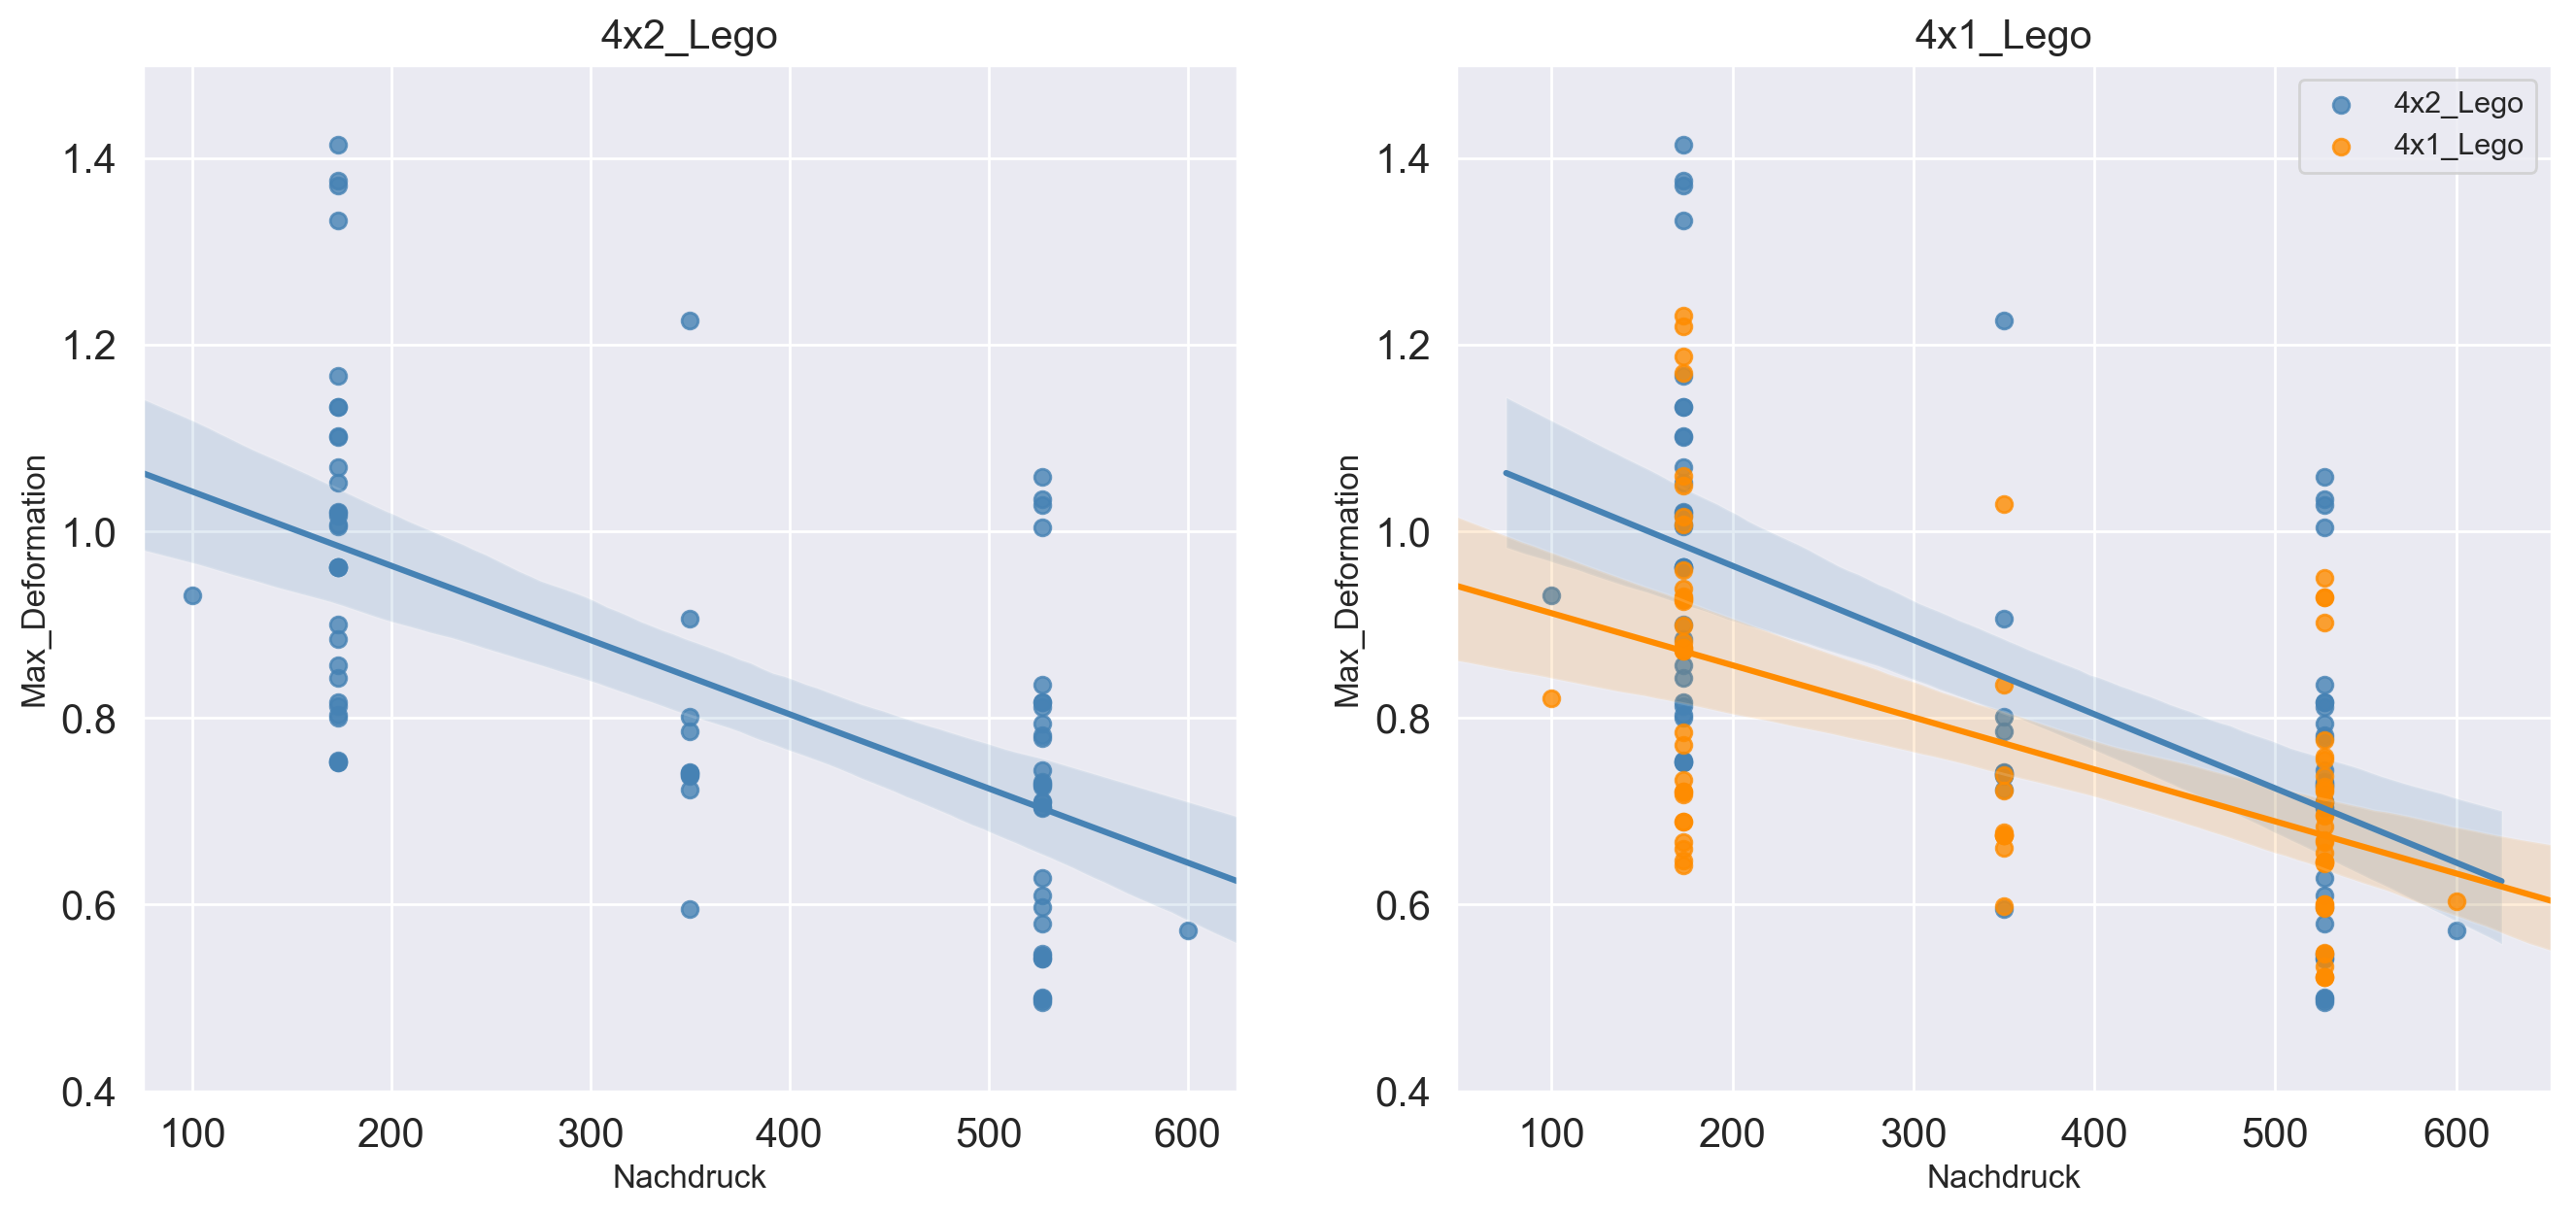

In [6]:
feature_list = ['Max_Deformation', 'Nachdruck', 'Nachdruckzeit', 'Schmelzetemperatur', 'Wandtemperatur', 'Kuehlzeit', 'Volumenstrom']

part_1_name = '4x2_Lego'
part_2_name = '4x1_Lego'

lego_1 = data.loc[data['Legobaustein'] == part_1_name][feature_list]
lego_2 = data.loc[data['Legobaustein'] == part_2_name][feature_list]

sns.set()
fig = plt.figure(figsize=(16,7))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title(part_1_name, fontsize=15)
ax2.set_title(part_2_name, fontsize=15)

ax1.set_ylim(0.4, 1.5)
ax2.set_ylim(0.4, 1.5)

ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=15)
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)

sns.regplot(lego_1['Nachdruck'], lego_1['Max_Deformation'], color='steelblue', ax=ax1)
sns.regplot(lego_1['Nachdruck'], lego_1['Max_Deformation'], color='steelblue', ax=ax2, label=part_1_name)
sns.regplot(lego_2['Nachdruck'], lego_2['Max_Deformation'], color='darkorange', ax=ax2, label=part_2_name)
plt.legend()

## Create data dictionaries
Split the data into separate sets (one set per lego brick). Each data set is split into training set (~57 records), validation set (~8 records), and training set (~12 records). In addition, we scale the features for better training of the neural network regressor.
The method returns a dictionary containing all the data sets for each lego brick. 

In [7]:
def load_data_dict(train_percentage, val_percentage, test_percentage):
    """
    This method loads the data for all parts. 
    :return: A dictionary containing the raw and pre processed data used to fit the model.
    """
    set_seeds(1273)
    scale = StandardScaler()
    data_path = "Data/Part_Data/lego_data.csv"
    data_dict = {}
    parameters = np.array(['Nachdruck', 'Nachdruckzeit', 'Schmelzetemperatur', 'Wandtemperatur', 'Kuehlzeit', 'Volumenstrom'])
    quality_criteria = np.array(['Max_Deformation'])
    n_inputs = len(parameters)
    n_outputs = len(quality_criteria)

    data = pd.read_csv(data_path, sep=';')
    
    # iterate over all lego bricks (e.g. 4x2, 3x1, 4x1)
    for value in data['Legobaustein'].unique():
        mask = data['Legobaustein'] == value
        data_reduced = data[mask]
        data_reduced = data_reduced[np.append(parameters, quality_criteria)]
        data_dict[value] = {}

        data_reduced = shuffle(data_reduced, random_state=seed)

        # data is divided into training, covalidation and testing sets
        data_n = len(data_reduced)

        train_data = data_reduced.values[0:int(data_n * train_percentage)]

        cval_data = data_reduced.values[
                    int(data_n * train_percentage):int(data_n * (train_percentage + val_percentage))]

        test_data = data_reduced.values[int(data_n * (train_percentage + val_percentage)):int(
            data_n * (train_percentage + val_percentage + test_percentage))]

        # Pytorch Tensor objects for the data sets are created with X data scaled fitted to train data
        data_dict[value]["train_x"] = torch.from_numpy(scale.fit_transform(train_data[:, 0:n_inputs])).float()
        data_dict[value]["train_y"] = torch.from_numpy(train_data[:, n_inputs:n_inputs + n_outputs]).float()

        data_dict[value]["val_x"] = torch.from_numpy(scale.transform(cval_data[:, 0:n_inputs])).float()
        data_dict[value]["val_y"] = torch.from_numpy(cval_data[:, n_inputs:n_inputs + n_outputs]).float()

        data_dict[value]["test_x"] = torch.from_numpy(scale.transform(test_data[:, 0:n_inputs])).float()
        data_dict[value]["test_y"] = torch.from_numpy(test_data[:, n_inputs:n_inputs + n_outputs]).float()

    return data_dict

###### Print data dictionary

In [8]:
data_dict = load_data_dict(0.75, 0.15, 0.1)
print('Number of parts: {}'.format(len(data_dict)))
data_dict

Number of parts: 48


{'3x1_Lego_flach': {'train_x': tensor([[ 1.0978,  1.0599, -1.1362, -1.1362, -1.0939, -1.0598],
          [-1.0599, -1.0977,  1.0226,  1.0226, -1.0939,  1.0977],
          [-1.0599, -1.0977, -1.1362, -1.1362, -1.0939, -1.0598],
          [ 1.0978,  1.0599, -1.1362,  1.0226,  1.1095,  1.0977],
          [ 1.0978, -1.0977,  1.0226,  1.0226,  1.1095,  1.0977],
          [ 1.0978, -1.0977, -1.1362,  1.0226,  1.1095, -1.0598],
          [ 0.0189, -1.5433, -0.0568, -0.0568,  0.0078,  0.0189],
          [ 1.0978,  1.0599, -1.1362,  1.0226, -1.0939,  1.0977],
          [-1.0599, -1.0977, -1.1362,  1.0226,  1.1095,  1.0977],
          [ 1.0978,  1.0599,  1.0226,  1.0226, -1.0939, -1.0598],
          [ 1.5427, -0.0189, -0.0568, -0.0568,  0.0078,  0.0189],
          [ 0.0189, -0.0189, -0.0568, -0.0568,  0.0078, -1.5066],
          [ 1.0978, -1.0977, -1.1362, -1.1362, -1.0939, -1.0598],
          [ 1.0978, -1.0977, -1.1362,  1.0226, -1.0939, -1.0598],
          [-1.0599, -1.0977,  1.0226, -1.1362, 

## PyTorch: Methods to create and train neural networks
At first, we define the class for the neural network model using inherited attributes from the Module class in Pytorch.

In [9]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(6, 45)
        self.fc2 = nn.Linear(45, 20)
        self.fc3 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

For the upcoming experiments, we use DataLoaders from Pytorch to load the respective training or validation set. The fraction denotes how much proportion of the training set is to be loaded. 

In [10]:
def get_loader(data_dict, part, fraction):
    train_x = data_dict[part]['train_x'] 
    train_y = data_dict[part]['train_y']
    train_x = train_x[:int(fraction * len(train_x))]
    train_y = train_y[:int(fraction * len(train_y))]
    train_dataset = TensorDataset(train_x, train_y)
    trainloader = DataLoader(train_dataset, batch_size=10)

    val_x = data_dict[part]['val_x']
    val_y = data_dict[part]['val_y']
    val_dataset = TensorDataset(val_x, val_y)
    valloader = DataLoader(val_dataset, batch_size=10)
    return trainloader, valloader

Then, we define the method for the training of the model and its validation. In the process the model will train through every batch until the validation loss has not improved for the amount of epochs specified in patience. The trained model and the amount of epochs required are returned.

In [11]:
def train_model(model, optimizer, criterion, trainloader, valloader, num_epochs, patience=100, logging=True, early_stopping=True):

    # early stop parameters
    delta = 0.00001
    stop = False
    best_loss = None
    counter = 0
    for epoch in range(num_epochs):
        # per epoch the model is trained on all batches of the training dataset
        num_batches = 0
        batch_loss = 0.0
        val_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            model.train()
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            batch_loss += loss.item()
            num_batches += 1

        epoch_loss = batch_loss / num_batches
        
        # the model is then evaluated on all batches of the validation dataset
        num_batches = 0.0
        for batch_idx, (inputs, targets) in enumerate(valloader):
            model.eval()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            num_batches += 1
        val_loss = val_loss / num_batches

        
        # Early stoppging: training stops if no improvement in validation loss
        if early_stopping:
            if best_loss is None:
                best_loss = val_loss
            elif val_loss < best_loss - delta:
                best_loss = val_loss
                counter = 0
            else:
                counter += 1
                if counter >= patience:
                    stop = True
        
        if epoch % 100 == 0:
            if logging:
                print('Train Epoch: {} \tTrain_Loss: {:.6f} \t Validation_Loss: {:.6f}, Best_Loss: {:.6f}'.format(epoch, epoch_loss, val_loss, best_loss))

        if stop:
            if logging:
                print("EARLY STOPPING at epoch {}".format(epoch))
            break
    return model, epoch

Now we define the method for evaluating the model's accuracy on a test set. The metric used is the coefficient of determination R² from the scikit-learn library. It is define as follows:
<img src="images/r2_score_formular.png" width="600">
The R² score is then returned.

In [12]:
def evaluate_model(model, test_x, test_y):
    model.eval()
    with torch.no_grad():
        test_x, test_y = test_x.to(device), test_y.to(device)
        net_out = model(test_x)
        score = r2_score(net_out.cpu().numpy(), test_y.cpu().numpy())
    return score

## Transfer Learning (lego brick to lego brick)

In the following, we implement transfer learning by fitting a the network on one dateset and finetuning the network on a second data set. 

First, we load the data and set the device to gpu.

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_dict = load_data_dict(0.75, 0.1, 0.15)

#### Train on first lego brick (4x2)

In [14]:
part = '4x2_Lego'
set_seeds(seed)
trainloader, valloader = get_loader(data_dict, part, 1.0)

model = Net()
model.to(device)
model.train()
optimizer = optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001, amsgrad=True)
criterion = nn.L1Loss()
model, part_1_epochs = train_model(model, optimizer, criterion, trainloader, valloader, num_epochs=1000)

test_x, test_y = data_dict[part]['test_x'], data_dict[part]['test_y']
model.eval()
part_1_test_score = evaluate_model(model, test_x, test_y)
print('*' * 30)
print('Test score part 1: {:.4f}'.format(part_1_test_score))

Train Epoch: 0 	Train_Loss: 0.717228 	 Validation_Loss: 0.206858, Best_Loss: 0.206858
Train Epoch: 100 	Train_Loss: 0.019811 	 Validation_Loss: 0.021423, Best_Loss: 0.013559
Train Epoch: 200 	Train_Loss: 0.014851 	 Validation_Loss: 0.030211, Best_Loss: 0.009258
Train Epoch: 300 	Train_Loss: 0.015936 	 Validation_Loss: 0.020708, Best_Loss: 0.008642
EARLY STOPPING at epoch 371
******************************
Test score part 1: 0.9941


#### Transfer the trained model to second lego brick (by continuing the training)
Note that we use only **20%** of the training data for the second part

In [17]:
part = '3x1_Lego'
set_seeds(seed)
trainloader, valloader = get_loader(data_dict, part, 0.2)

model.train()
optimizer = optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001, amsgrad=True)
model, part_2_tl_epochs = train_model(model, optimizer, criterion, trainloader, valloader, num_epochs=1000)

test_x, test_y = data_dict[part]['test_x'], data_dict[part]['test_y']
model.eval()
part_2_tl_test_score = evaluate_model(model, test_x, test_y)
print('*' * 30)
print('Test score part 2 (finetune): {:.4f}'.format(part_2_tl_test_score))

Train Epoch: 0 	Train_Loss: 0.034113 	 Validation_Loss: 0.081893, Best_Loss: 0.081893
Train Epoch: 100 	Train_Loss: 0.011868 	 Validation_Loss: 0.064840, Best_Loss: 0.047242
EARLY STOPPING at epoch 142
******************************
Test score part 2 (finetune): 0.7589


#### For comparison: training a model for the second lego brick from scratch
Note that we re-initialize the network and that we use only **20%** of the training data for the second part

In [16]:
part = '3x1_Lego'
set_seeds(seed)
trainloader, valloader = get_loader(data_dict, part, 0.2)

model = Net()
model.to(device)
model.train()
optimizer = optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001, amsgrad=True)
model, part_2_epochs = train_model(model, optimizer, criterion, trainloader, valloader, num_epochs=1000)

test_x, test_y = data_dict[part]['test_x'], data_dict[part]['test_y']
model.eval()
part_2_test_score = evaluate_model(model, test_x, test_y)
print('*' * 30)
print('Test score part 2 (from scratch): {:.4f}'.format(part_2_test_score))

Train Epoch: 0 	Train_Loss: 0.699138 	 Validation_Loss: 0.657782, Best_Loss: 0.657782
Train Epoch: 100 	Train_Loss: 0.025324 	 Validation_Loss: 0.070335, Best_Loss: 0.065364
Train Epoch: 200 	Train_Loss: 0.012689 	 Validation_Loss: 0.079146, Best_Loss: 0.051564
Train Epoch: 300 	Train_Loss: 0.007049 	 Validation_Loss: 0.048712, Best_Loss: 0.041746
EARLY STOPPING at epoch 396
******************************
Test score part 2 (from scratch): 0.7305


#### Plot Results
Comparison of training on part 1, transfer (finetuning) on lego brick 2, and training on lego brick 2 from scratch. The plots show the R² scores as well as the number of epochs used for training. Note that for lego brick 2, only 20% of the data was used. 

<BarContainer object of 3 artists>

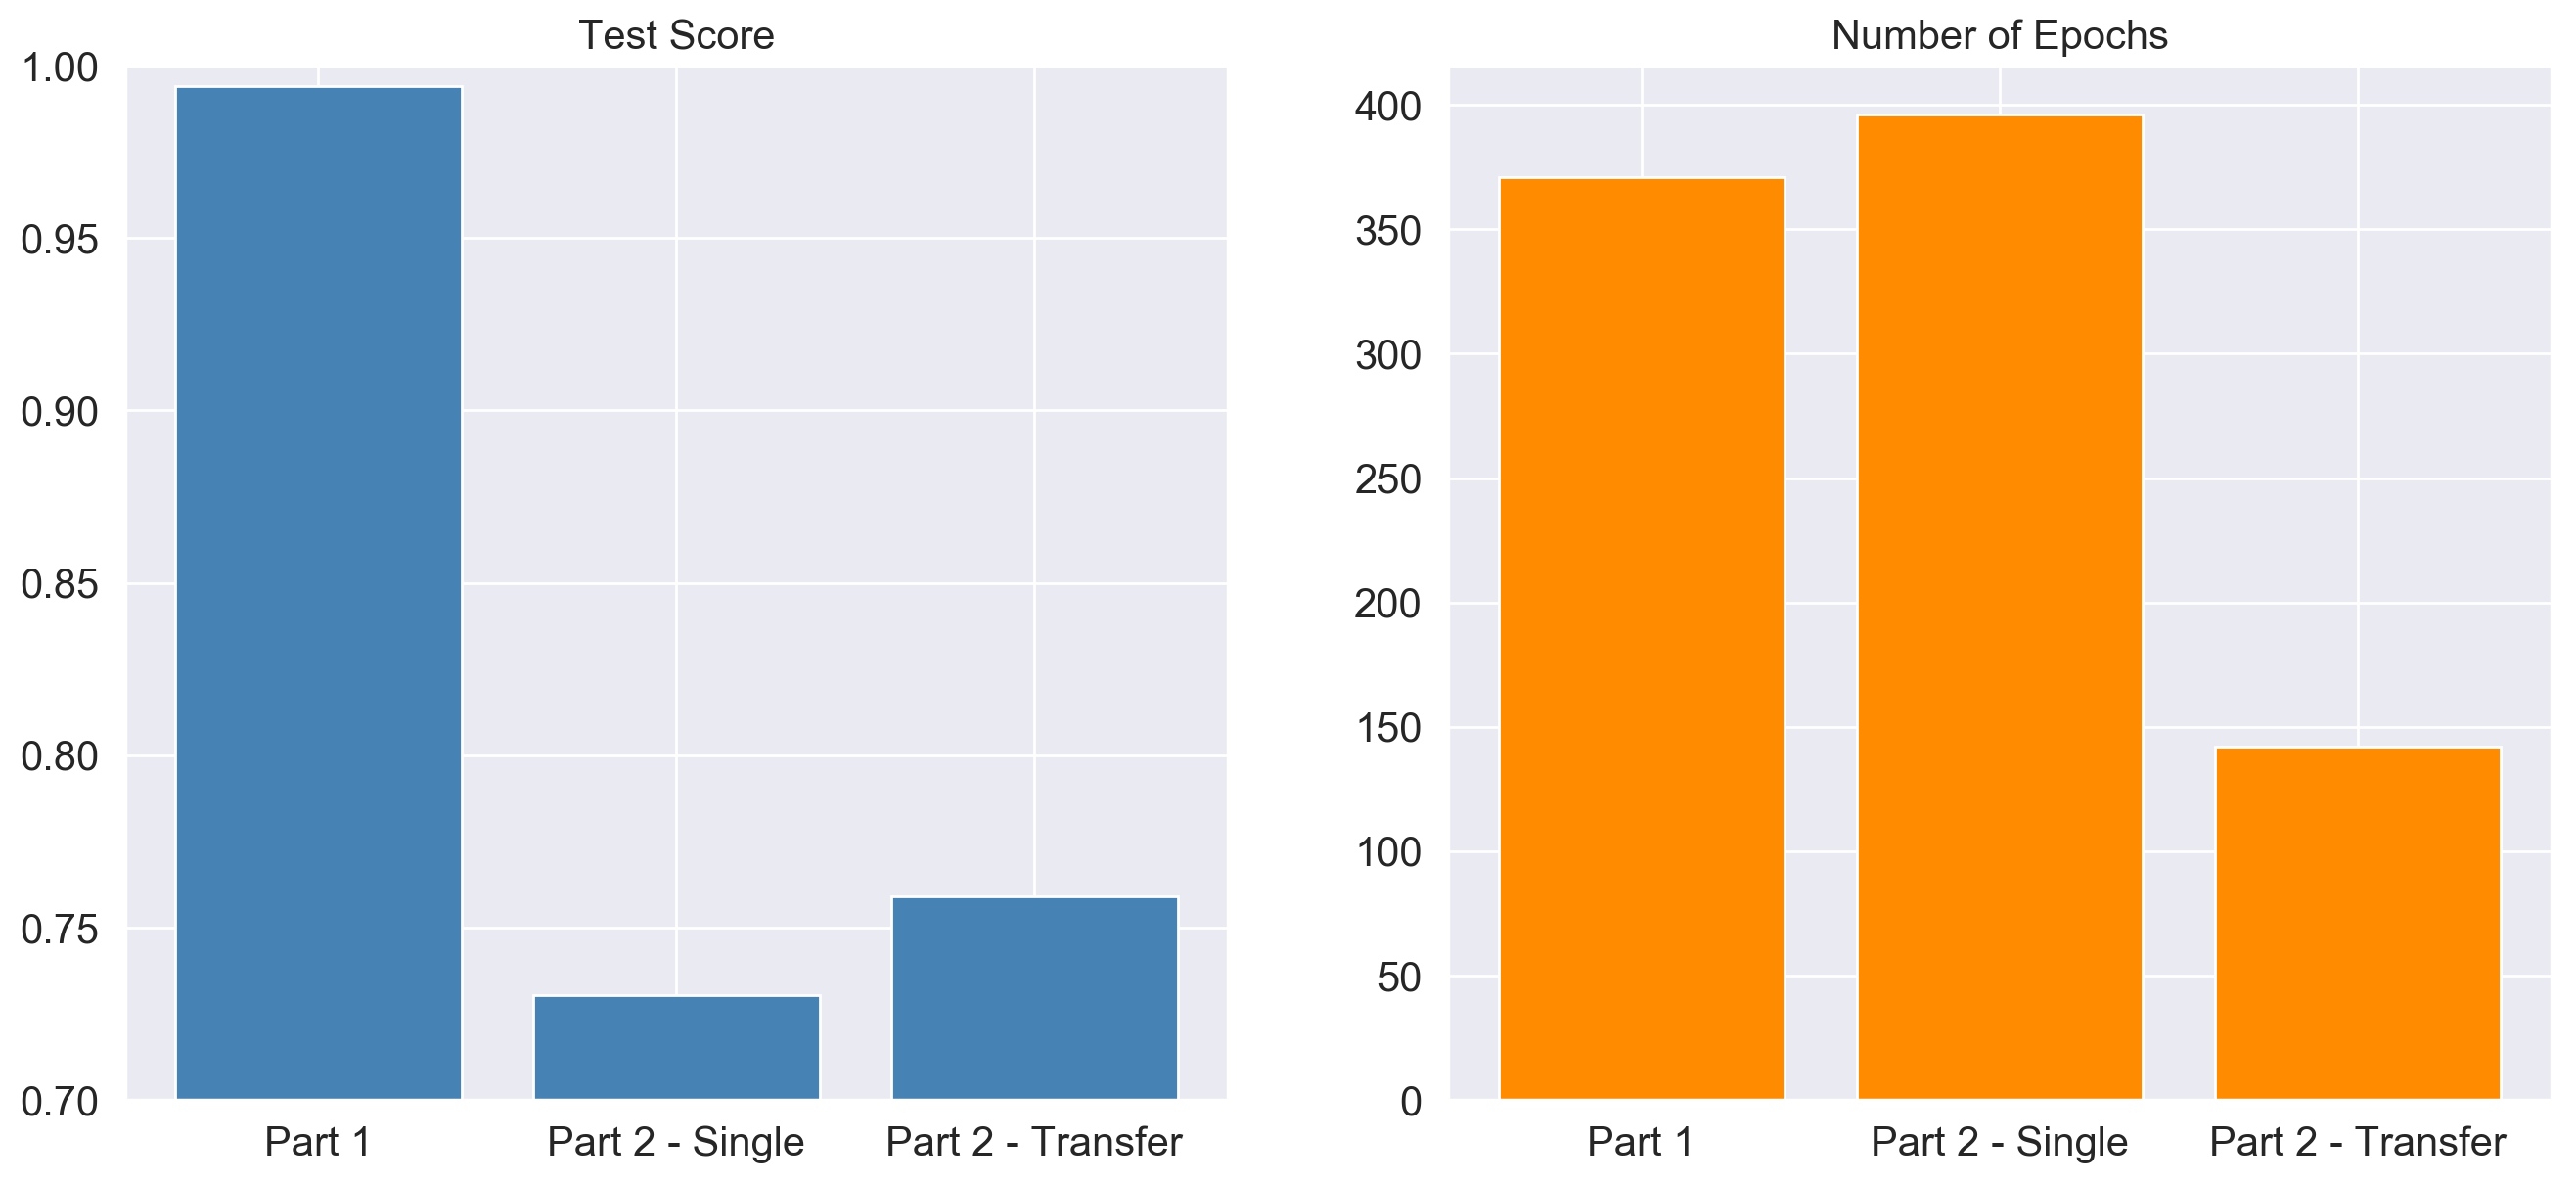

In [18]:
sns.set()
fig = plt.figure(figsize=(16,7))

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.set_title('Test Score', fontsize=15)
ax2.set_title('Number of Epochs', fontsize=15)

ax1.set_ylim(0.7, 1.0)

ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=15)
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=15)


ax1.bar(["Part 1", "Part 2 - Single", "Part 2 - Transfer"], [part_1_test_score, part_2_test_score, part_2_tl_test_score], color='steelblue')
ax2.bar(["Part 1", "Part 2 - Single", "Part 2 - Transfer"], [part_1_epochs, part_2_epochs, part_2_tl_epochs], color='darkorange')

## Transfer Learning (lego brick to lego brick) with incremental scores

In the following, we implement the same methods with additional evaluation. We train the model for the second lego brick on different data sizes to compare the performance between transfer learning and training from scratch. 

#### Train on first lego brick (4x2) and finetune the network to the second lego brick (3x1): training on different proportions of data

In [20]:
part = '4x2_Lego'
set_seeds(seed)
trainloader, valloader = get_loader(data_dict, part, 1.0)
print('Train on first lego brick')
model = Net()
model.to(device)
model.train()
optimizer = optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001, amsgrad=True)
criterion = nn.L1Loss()
model, epochs = train_model(model, optimizer, criterion, trainloader, valloader, num_epochs=1000, logging=False)


part = '3x1_Lego'
set_seeds(seed)
print('Transfer on second lego brick')
fractions = np.arange(0.1, 1.01, 0.1)
scores_frac = []
bck_model = copy.deepcopy(model)
for frac in fractions:
    trainloader, valloader = get_loader(data_dict, part, frac)

    model = copy.deepcopy(bck_model)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001, amsgrad=True)
    model, epochs = train_model(model, optimizer, criterion, trainloader, valloader, num_epochs=1000, logging=False)

    test_x, test_y = data_dict[part]['test_x'], data_dict[part]['test_y']
    model.eval()
    test_score = evaluate_model(model, test_x, test_y)
    print('Test score for fraction {:.1f}: {:.4f}'.format(frac, test_score))
    scores_frac.append(max(-2.0, test_score))
transfer_scores_frac = scores_frac

Train on first lego brick
Transfer on second lego brick
Test score for fraction 0.1: 0.8839
Test score for fraction 0.2: 0.8928
Test score for fraction 0.3: 0.9585
Test score for fraction 0.4: 0.9498
Test score for fraction 0.5: 0.9656
Test score for fraction 0.6: 0.9614
Test score for fraction 0.7: 0.9867
Test score for fraction 0.8: 0.9738
Test score for fraction 0.9: 0.9705
Test score for fraction 1.0: 0.9856


#### For comparison: train the network for the second lego brick from scratch, again on different proportions of data

In [21]:
part = '3x1_Lego'
set_seeds(seed)
print('Train on second lego brick from scratch')
fractions = np.arange(0.1, 1.01, 0.1)
scores_frac = []
for frac in fractions:
    trainloader, valloader = get_loader(data_dict, part, frac)
    model = Net()
    model.to(device)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001, amsgrad=True)
    model, epochs = train_model(model, optimizer, criterion, trainloader, valloader, num_epochs=1000, logging=False)

    test_x, test_y = data_dict[part]['test_x'], data_dict[part]['test_y']
    model.eval()
    test_score = evaluate_model(model, test_x, test_y)
    print('Test score for fraction {:.1f}: {:.4f}'.format(frac, test_score))
    scores_frac.append(max(-2.0, test_score))
control_scores_frac = scores_frac

Train on second lego brick from scratch
Test score for fraction 0.1: 0.4289
Test score for fraction 0.2: 0.7420
Test score for fraction 0.3: 0.1863
Test score for fraction 0.4: 0.8233
Test score for fraction 0.5: 0.8769
Test score for fraction 0.6: 0.9748
Test score for fraction 0.7: 0.9454
Test score for fraction 0.8: 0.9725
Test score for fraction 0.9: 0.8619
Test score for fraction 1.0: 0.9810


#### Plot Results
Comparison of transfer (finetuning) on lego brick 2 and training on lego brick 2 from scratch. The plots show the R² scores over varying data sizes (proportions).

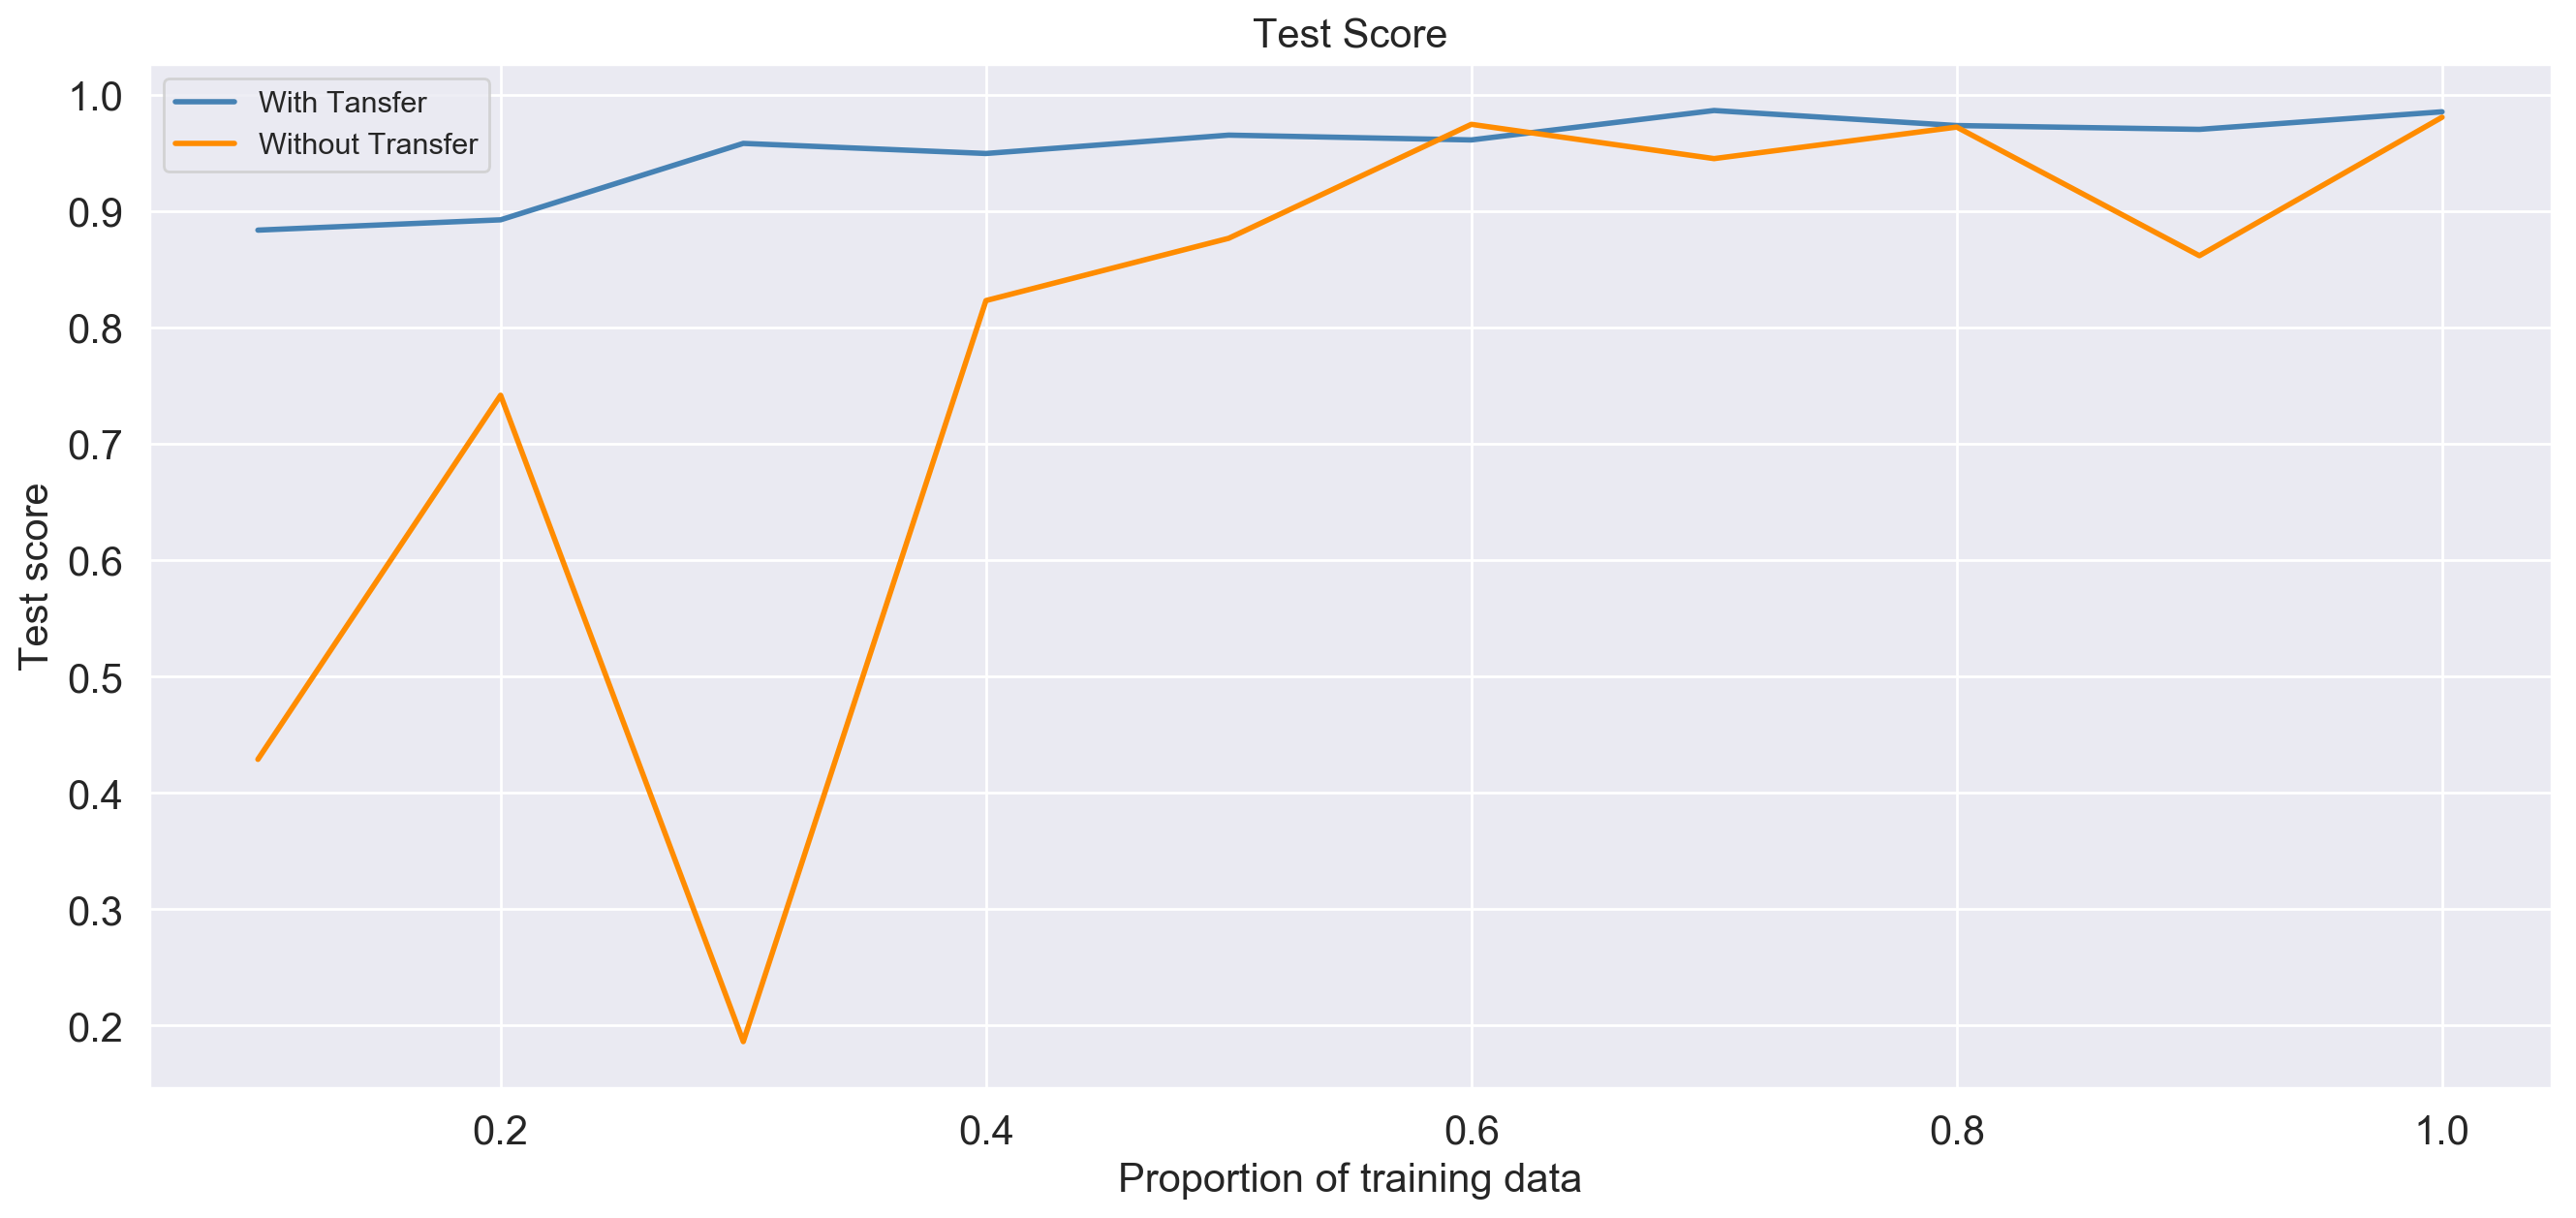

In [22]:
fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(111)
ax.set_title('Test Score', fontsize=15)

xaxis = np.arange(0.1, 1.01, 0.1)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xlabel('Proportion of training data', fontsize=15)
ax.set_ylabel('Test score', fontsize=15)
ax.plot(xaxis, transfer_scores_frac, color='steelblue', label='With Tansfer', linewidth=2)
ax.plot(xaxis,control_scores_frac, color='darkorange', label='Without Transfer', linewidth=2)
plt.legend()

## Transfer Learning for 3 lego bricks

In the following, we apply two-time-transfer from lego brick "3x2" to "4x2" to "3x1" and print the incremental results for the last transfer. This is an extension of the previous transfer (from "4x2" to "3x1").

In [ ]:
part = '3x2_Lego'
set_seeds(seed)
trainloader, valloader = get_loader(data_dict, part, 1.0)

print('Train on first lego brick')
model = Net()
model.to(device)
model.train()
optimizer = optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001, amsgrad=True)
criterion = nn.L1Loss()
model, epochs = train_model(model, optimizer, criterion, trainloader, valloader, num_epochs=1000, logging=False)


part = '4x2_Lego'
set_seeds(seed)
trainloader, valloader = get_loader(data_dict, part, 1.0)

print('Transfer on second lego brick')
model.train()
optimizer = optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001, amsgrad=True)
model, epochs = train_model(model, optimizer, criterion, trainloader, valloader, num_epochs=1000, logging=False)

part = '3x1_Lego'
set_seeds(seed)
print('Transfer on third lego brick')
fractions = np.arange(0.1, 1.01, 0.1)
scores_frac = []
bck_model = copy.deepcopy(model)
for frac in fractions:
    trainloader, valloader = get_loader(data_dict, part, frac)

    model = copy.deepcopy(bck_model)
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001, amsgrad=True)
    model, epochs = train_model(model, optimizer, criterion, trainloader, valloader, num_epochs=1000, logging=False)

    test_x, test_y = data_dict[part]['test_x'], data_dict[part]['test_y']
    model.eval()
    test_score = evaluate_model(model, test_x, test_y)
    print('Test score for fraction {:.1f}: {:.4f}'.format(frac, test_score))
    scores_frac.append(max(-2.0, test_score))
double_transfer_scores_frac = scores_frac

#### Plot Results
Comparison of the 3 approaches: 
-  training from scratch (on 3x1)
-  1-time-transfer with finetuning (4x2 to 3x1)
-  2-time-transfer with finetuning (3x2 to 4x2 to 3x1)

The plots show the R² scores over varying data sizes (proportions) for the last lego brick (3x1). The red line indicatas a threshold of the score at 0.95. 

In [ ]:
fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(111)
ax.set_title('Test Score', fontsize=15)

xaxis = np.arange(0.1, 1.01, 0.1)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.set_xlabel('Proportion of training data', fontsize=15)
ax.set_ylabel('Test score', fontsize=15)
ax.plot(xaxis, control_scores_frac, color='darkorange', label='Without Transfer', linewidth=2)
ax.plot(xaxis, transfer_scores_frac, color='steelblue', label='With 1 Tansfer', linewidth=2)
ax.plot(xaxis, double_transfer_scores_frac, color='darkgreen', label='With 2 Transfer', linewidth=2)
plt.axhline(y=0.95, color='r', linestyle='--', linewidth=1)
plt.legend()

## Mulitple transfer (3-time transfer with 4 lego bricks)

For illustration purpose: creating 24 different lists (permutations) out of 4 lego bricks. 

In [23]:
part_list = ['4x2_Lego', '4x1_Lego', '3x1_Lego','3x2_Lego']
for idx, perm in enumerate(permutations(part_list)):
    print(idx, perm)
    # for seed in np.arange(10):        

0 ('4x2_Lego', '4x1_Lego', '3x1_Lego', '3x2_Lego')
1 ('4x2_Lego', '4x1_Lego', '3x2_Lego', '3x1_Lego')
2 ('4x2_Lego', '3x1_Lego', '4x1_Lego', '3x2_Lego')
3 ('4x2_Lego', '3x1_Lego', '3x2_Lego', '4x1_Lego')
4 ('4x2_Lego', '3x2_Lego', '4x1_Lego', '3x1_Lego')
5 ('4x2_Lego', '3x2_Lego', '3x1_Lego', '4x1_Lego')
6 ('4x1_Lego', '4x2_Lego', '3x1_Lego', '3x2_Lego')
7 ('4x1_Lego', '4x2_Lego', '3x2_Lego', '3x1_Lego')
8 ('4x1_Lego', '3x1_Lego', '4x2_Lego', '3x2_Lego')
9 ('4x1_Lego', '3x1_Lego', '3x2_Lego', '4x2_Lego')
10 ('4x1_Lego', '3x2_Lego', '4x2_Lego', '3x1_Lego')
11 ('4x1_Lego', '3x2_Lego', '3x1_Lego', '4x2_Lego')
12 ('3x1_Lego', '4x2_Lego', '4x1_Lego', '3x2_Lego')
13 ('3x1_Lego', '4x2_Lego', '3x2_Lego', '4x1_Lego')
14 ('3x1_Lego', '4x1_Lego', '4x2_Lego', '3x2_Lego')
15 ('3x1_Lego', '4x1_Lego', '3x2_Lego', '4x2_Lego')
16 ('3x1_Lego', '3x2_Lego', '4x2_Lego', '4x1_Lego')
17 ('3x1_Lego', '3x2_Lego', '4x1_Lego', '4x2_Lego')
18 ('3x2_Lego', '4x2_Lego', '4x1_Lego', '3x1_Lego')
19 ('3x2_Lego', '4x2_L

The plot shows the average proportion of data records needed for training to reach a test score of 0.95: 
1.  Training from scratch (part 1)
2.  First transfer (part 2)
3.  Second transfer (part 3)
4.  Third transfer (part 4)

Note that the averages are calculated across all permutations, whereas each experiment is conducted 10 times (with 10 different seeds). The conducted experiments are not part of this notebook. 

[0.60375    0.3875     0.37229167 0.345     ]


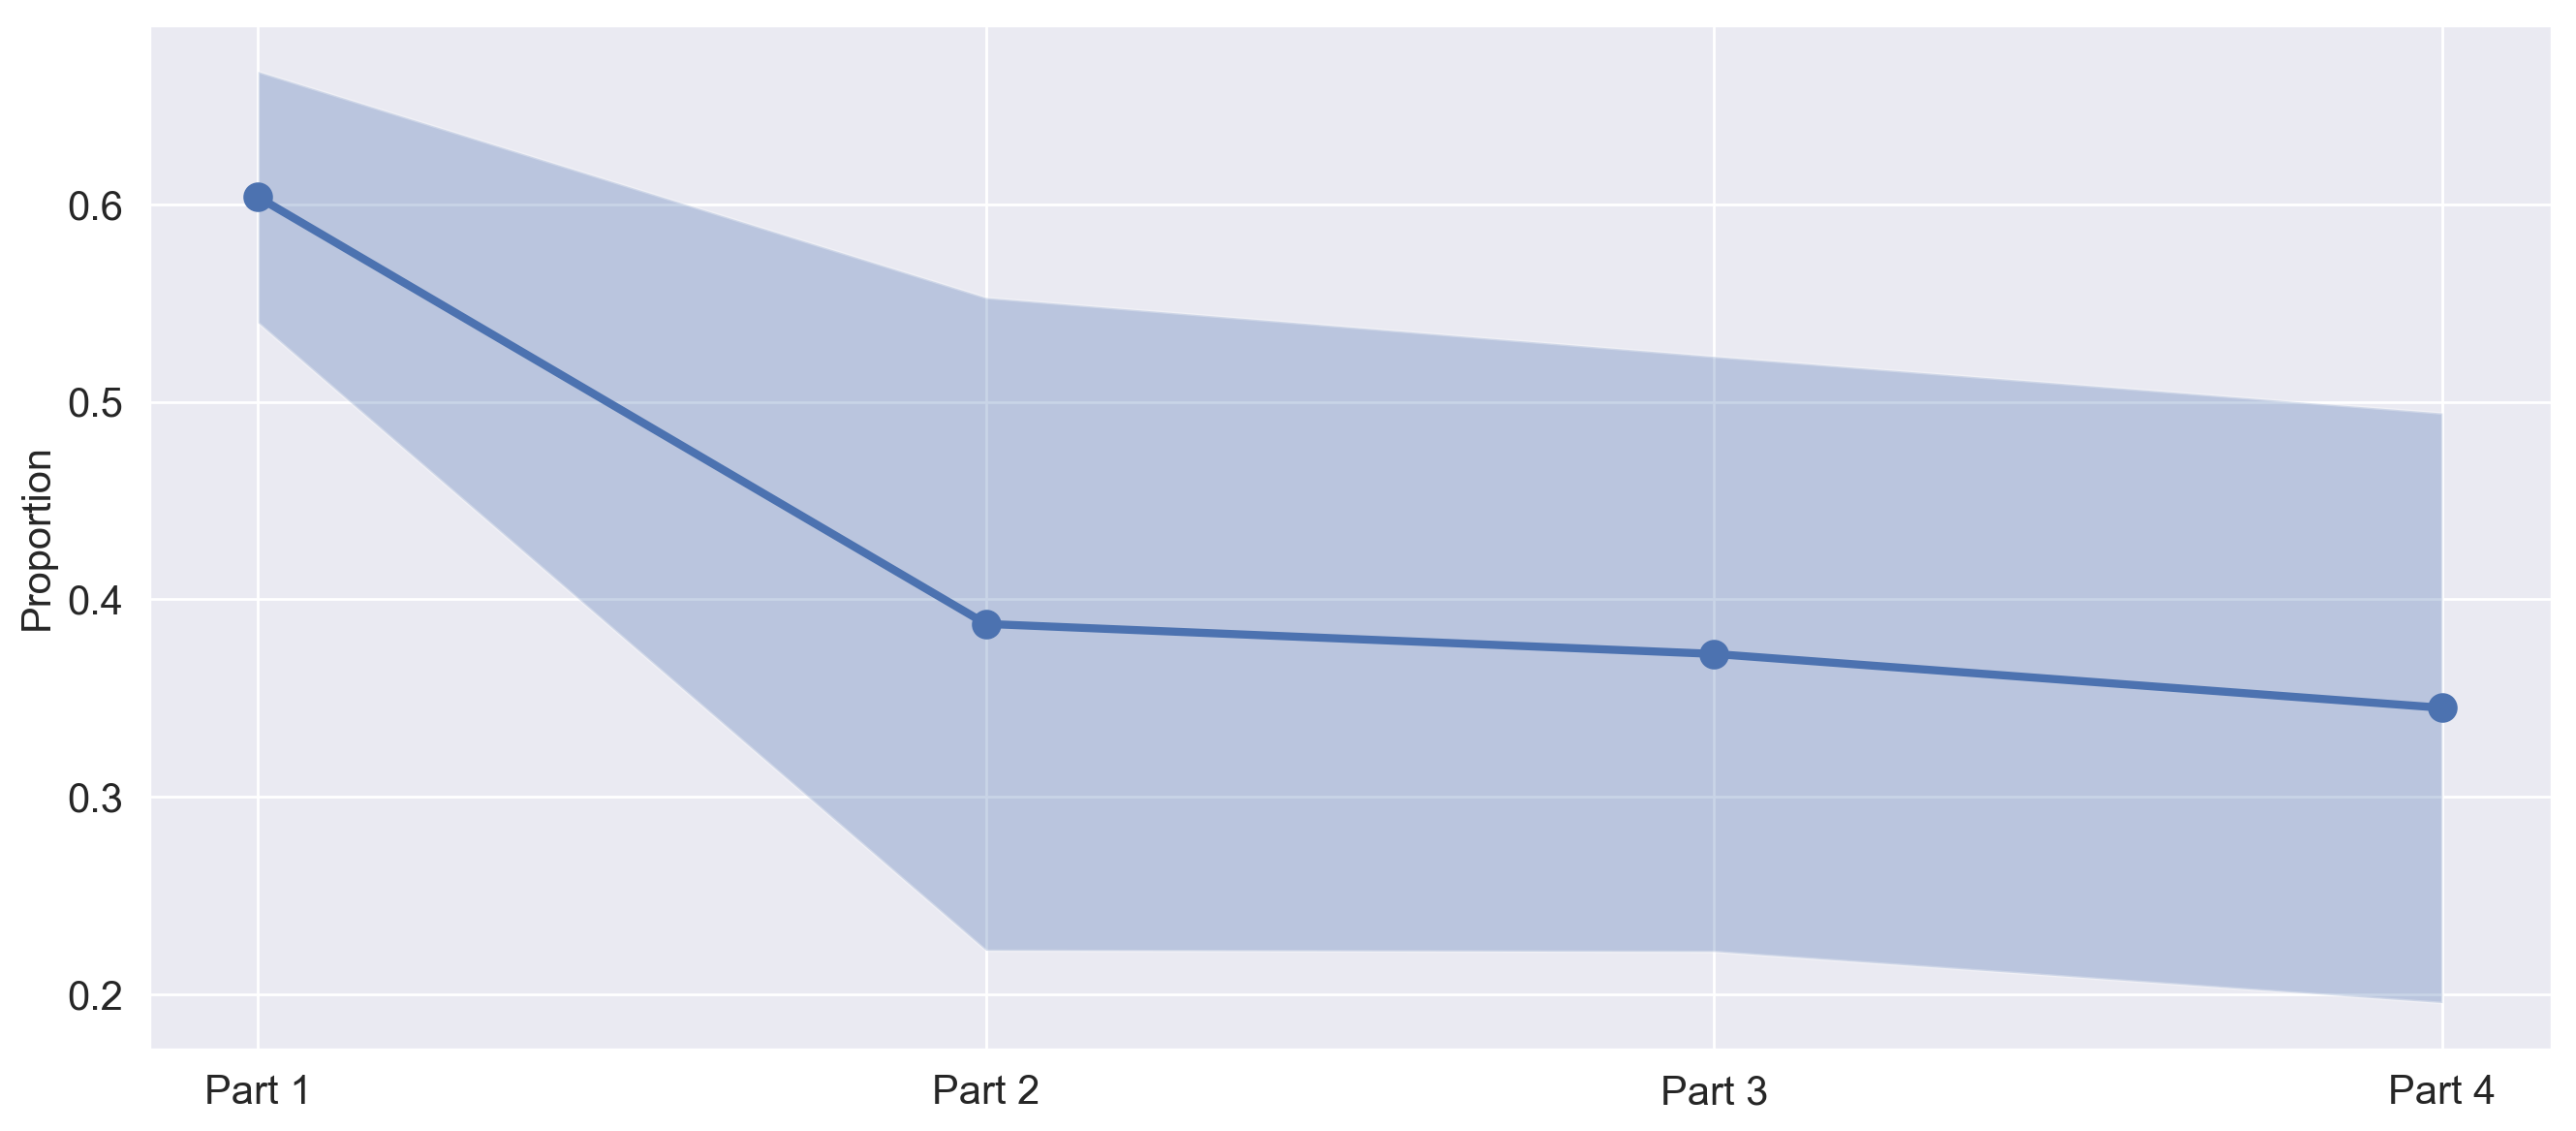

In [24]:
scores = []
for filename in os.listdir('Results/transfer_finetune_permutations'):
    if filename[0:35] == 'transfer_finetune_fracs_permutation':
        scores.append(np.loadtxt('Results/transfer_finetune_permutations/{}'.format(filename)))
scores = np.array(scores)
mean_scores = np.mean(scores, axis=0)
std_scores = np.std(scores, axis=0)
print(mean_scores)

sns.set()
fig = plt.figure(figsize=(16,7))
ax = fig.add_subplot(111)
x_axis = ['Part 1', 'Part 2', 'Part 3', 'Part 4']
ax.set_ylabel('Proportion', fontsize=15)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.plot(x_axis, mean_scores, marker='o', markersize=10, linewidth=3)
ax.fill_between(x_axis, mean_scores + std_scores, mean_scores - std_scores, alpha=0.3)